# Example 6 (EX6)

__Summary:__  In the last exercise we go for a full moist GCM simulation, with precipitation parameterisations turned on. The objective here is to create a reference run and have a look at the model output. So we start from an instantaneous observed state and run the model for longer. There are many diagnostics to look at from this run, both time average and time dependent. You can use this as the jumping-off point for your personal DREAM project. Or if you’re more academically minded you might find inspiration in one of the earlier exercises. 

### How to run the model and produce netcdf outputs:

* Go to the terminal window.
* Go to the jobs directory: `cd  ~/work/DREAM/dream_model/jobs`
* Run the model script: `./runmodel_v8.4_EX6.sh`.
* 
* Then in the terminal go to the diagnostics directory: `cd ~/work/DREAM/dream_model/diagnostics/`,
* Edit the script `run_output.sh` before running it: we wont substract the mean or anything from the simulation this time: Around line 60, set `lsubtractsp=false` and `ltangent=false` and . Also this time we need to output precip, so set  `lreadgrid2d=true` and `lbinppt=true`.
* Run the diagnostics script: `./run_output.sh EX6`. 
* The model outputs and diagnostics will be saved in `DREAM/dream_results/EX5b
* /netcdfs/`

### Open and plot results with Python

#### Import Python Packages


In [1]:
## standart libraries
import os,sys
import numpy as np

# xarray
import xarray as xr
    
# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import cartopy.util as ccu
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colormaps

import ipywidgets as widgets
from IPython.display import display, HTML, Image, clear_output



# My custom module with plot tools
import utils_SLX_plots_dream as slx


# Only if using jupyter notebook. Otherwise, comment out.
%matplotlib inline 

---
# Read DREAM model outputs:

* Set parameters:

In [2]:
EXPID="EX6"

# local directory of input files (in the DOcker container)
diri = "/home/jovyan/work/DREAM/dream_results/"+EXPID+"/netcdfs/"

# input files
fili  = "dreamT31L15_ppt.nc"
fili2 = "dreamT31L15_chi_250.nc"
fili3 = "dreamT31L15_div_250.nc"

# where to save output plots and movies
diro = "/home/jovyan/work/DREAM/dream_results/"+EXPID+"/plots/"

* Read data (with the python package xarray):

In [3]:

ppt = xr.open_dataset(diri+fili,decode_times=True)['ppt'].squeeze()
chi = xr.open_dataset(diri+fili2,decode_times=True)['chi'].squeeze()
div = xr.open_dataset(diri+fili3,decode_times=True)['d'].squeeze()


# number of time frames in this experiment
NTF=ppt.time.size
NTF

481

---
# Let's have a look at the simulated precipitation field!

In [9]:
# print info on the array
print(ppt)

<xarray.DataArray 'ppt' (time: 481, lat: 48, lon: 96)> Size: 18MB
[2216448 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 384B -87.16 -83.48 -79.78 ... 79.78 83.48 87.16
  * lon      (lon) float64 768B 0.0 3.75 7.5 11.25 ... 345.0 348.8 352.5 356.2
  * time     (time) datetime64[ns] 4kB 1900-01-01 ... 1900-05-01
Attributes:
    units:          mm/day
    long_name:      precipitation rate
    standard_name:  precipitation rate


* Print max, min, mean values of all array

In [10]:
print(ppt.max().values)
print(ppt.mean().values)
print(ppt.min().values)

42.36236034383491
1.6038919897093353
0.0


#### Maps for all timeframe

In [4]:
#------------ geography
# Global plot? True/False
glo= True

# center longitude on:
loncentr=180.

# set coastL to True if you want coaslines
coastL=False

#------------ color shading

# type of plot (can be 'contourf', 'pcolormesh', defaut is contourf)

typlo='pcolormesh'

# min max values on the colorscale
vmin=0
vmax=20

# colormap

# Get the base colormap (no N argument)
base_cmap = colormaps.get_cmap('viridis_r')

# Manually sample 256 colors from the colormap
new_colors = base_cmap(np.linspace(0, 1, 256))

# Set the first color to white (for values <= 0)
new_colors[0] = [1, 1, 1, 1]  # RGBA

# Create the new colormap
new_cmap = ListedColormap(new_colors)

# number of color segments of the colormap
Nincr=20

# color of the values smaller than vmin
su='#EFF5FB'
# color of the values larger than vmax
so='#F8E0E0'

# colorbar label 
labelplt= "ppt ("+ppt.units+")"

# number of labels on the colorbar
Nbar=3

#------------ plot output
# plot format
pltty = ".png"


# plot resolution (dpi)
dpifig=200

# base name for output plot file
plti="PPT_"+EXPID


#### Plot and save single png maps for each timeframe

In [ ]:

# loop on all time steps in the data array:
for it in range(0,NTF,4):
     
        # this is to plor only once a day (when hour==00)
        #if (time.hour[it]==0):
                
            # output plot file name including the time index
            plto = plti+"."+str(it).zfill(4)
    

            # data to plot (must be a 2-d np.array)
            # here we select one timestep at a time for plotting purposes
            data2plot  = ppt.isel(time=it).values

            # make the data to plot cyclic so that the values at longitude 0 are repeated at 360. (for plot purposes)
            cyclic_data, cyclic_lons = ccu.add_cyclic_point(data2plot, coord=ppt.lon.values)

            #----------------------------------------------------
            #------ PLOT ----------------------------------------
            #----------------------------------------------------

            # create fig
            fig1 = plt.figure(figsize=([12,9]),facecolor='white')

            # plot data (base plot from plotmap functionn defined above)
            
            cs = slx.plotmap(fig1,cyclic_data,cyclic_lons,ppt.lat.values,plto,cm_base=new_cmap,vmin=vmin,vmax=vmax,Nincr=Nincr,glo=glo,coastL=coastL,su=su,so=so,loncentr=loncentr,typlo=typlo,Nbar=Nbar,labelplt=labelplt)

            # add title on plot (date)
            #plt.title(slx.printdatestring(airanom.time.to_index(),it))
            # Compute days since t0
            t0 = ppt.time[0].values
            current_time = ppt.time[it].values
            delta_days = (np.datetime64(current_time) - np.datetime64(t0)) / np.timedelta64(1, 'D')
            title_text = fig1.text(0.5, 0.8, f"t₀ + {delta_days:.2f} days", ha='center', fontsize=16)

            if it==1:
                # display plot only once in the loop
                plt.show()
    
            # Save fig in png, resolution dpi
            fig1.savefig(diro+"/"+plto+'.png', facecolor=fig1.get_facecolor(), edgecolor='none', dpi=dpifig,bbox_inches='tight', pad_inches=0)
            print("Saved to ... "+diro+"/"+plto+'.png')
            # close fig
            plt.close(fig1)    

#print("INITAL STATE:")
#display(Image(os.path.join(diro+"Z100_EX1b.101.png")))
#print('NOTE: All intermediate frames have been saved to '+diro)

Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0000.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0004.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0008.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0012.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0016.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0020.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0024.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0028.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0032.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0036.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0040.png
Saved to ... /home/jovyan/work/DREAM/dream_results/EX6/plots//PPT_EX6.0044.png
Saved to ... /home/jovyan/work/DREAM/dream_results/E


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0xffff43d37ce0> (for post_execute), with arguments args (),kwargs {}:


#### Display any of the time frames

In [5]:
# view figures
slider_expe = widgets.IntSlider(
    value=0,
    min=0,
    max=NTF-1,
    step=4,
    description='Time slider:',
    continuous_update=False
)
output_expe = widgets.Output()

def update_plot(it):
    with output_expe:
        clear_output(wait=True)
        tim = str(it).zfill(4)
        display(Image(filename=os.path.join(diro+"PPT_"+EXPID+"."+tim+".png")))

widgets.interact(update_plot, it=slider_expe)
display(output_expe)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time slider:', max=480, step=4)…

Output()

# Plot a hovmoller in the tropics

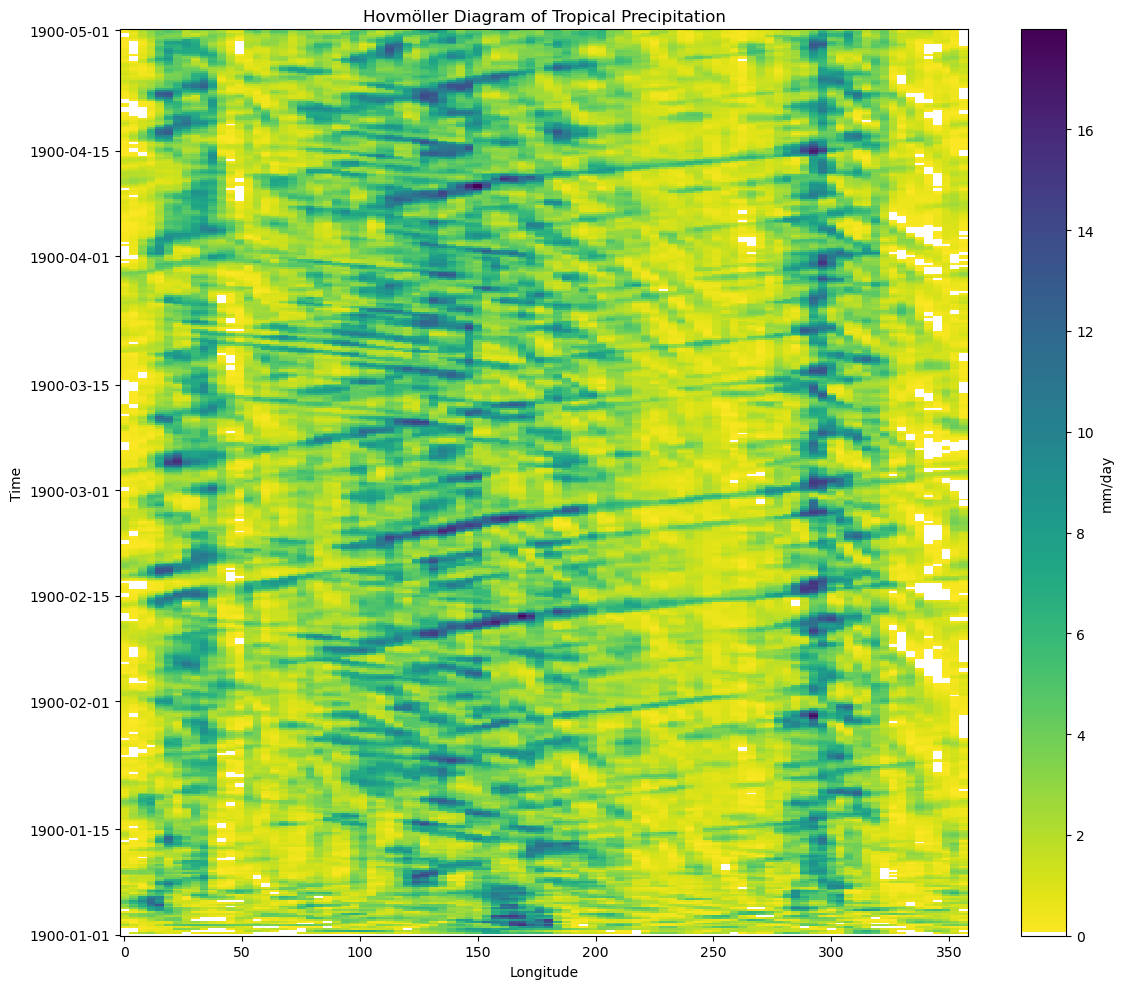

In [8]:
# Select tropical band (e.g., ±15° latitude)
ppt_tropics = ppt.sel(lat=slice(-15, 15))  # xarray sorts lat descending by default

# Average over the tropical latitudes
ppt_hov = ppt_tropics.mean(dim='lat')

# Plot Hovmöller diagram (time vs. longitude)
plt.figure(figsize=(12, 10))
ppt_hov.plot(
    x='lon', y='time', cmap=new_cmap, 
    cbar_kwargs={'label': ppt.attrs.get('units', 'mm/day')}
)

plt.title('Hovmöller Diagram of Tropical Precipitation')
plt.xlabel('Longitude')
plt.ylabel('Time')
plt.tight_layout()
plt.show()